**Import Library**

In [2]:
# !pip install --upgrade numpy scipy
# !pip install PyPortfolioOpt
# !pip install quantstats

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from pypfopt.plotting import plot_efficient_frontier
import quantstats as qs

**Read Files**

In [3]:
# set files
SET_expected_return = pd.read_csv('../Data/top_10_returns_SET1.csv')
SET_df = pd.read_csv('../Data/SET_main.csv')
set_index = pd.read_csv('../Data/set_index.csv')
set_predict = pd.read_csv('../Data/predictions_set.csv')

# sp500 files 
sp500_expected_return = pd.read_csv('../Data/top_10_returns_sp500.csv')
sp500_df = pd.read_csv('../Data/sp500_main.csv')
sp500_index = pd.read_csv('../Data/sp500_index.csv')
sp500_predict = pd.read_csv('../Data/predictions_sp500.csv')

In [8]:
sp500_expected_return

,Unnamed: 0,Expected Return (%)
0,NVDA,148.669016
1,META,97.482479
2,JPM,63.159531
3,AMZN,63.019192
4,LLY,60.158086
5,COST,57.258683
6,AVGO,55.203867
7,ORCL,54.855311
8,WMT,46.947178
9,GOOGL,42.660600


In [10]:
SET_expected_return

,Unnamed: 0,Expected Return (%)
0,TRUE.BK,51.305509
1,INTUCH.BK,38.682348
2,ADVANC.BK,34.294558
3,DELTA.BK,22.232005
4,KBANK.BK,21.553113
5,TTB.BK,18.725275
6,CPF.BK,12.934558
7,KTB.BK,10.439443
8,PTT.BK,8.446279
9,CPALL.BK,0.033943


In [12]:
# Putting the predicted values into the main dataframe instead of the true values 
set_no_date = SET_df.drop(columns=['Date'])
set_no_date.iloc[-360:] = set_predict

In [14]:
# Re_index to use it as a common columns 
set_no_date['Date'] = SET_df['Date']

# Merge the two files 
df = pd.merge(set_no_date, sp500_df,on='Date', how='inner').fillna(0)

# Bring Date columns to front
df = df[['Date'] + [col for col in df.columns if col != 'Date']]

# set Date as index 
df = df.set_index('Date')

In [27]:
df  =set_no_date
df = df.set_index('Date')

**Expected Return**

In [29]:
# Set the forecasted period 
forecasted_df = df.iloc[-360:]

# Calculating daily return for the forecasted period and select only the top 10 stocks that have the highest return
ER = expected_returns.mean_historical_return(forecasted_df).sort_values(ascending=False).head(10)

In [31]:
ER.keys()

Index(['TRUE.BK', 'IVL.BK', 'ADVANC.BK', 'DELTA.BK', 'KTB.BK', 'TTB.BK',
       'CPF.BK', 'MINT.BK', 'PTTEP.BK', 'CPALL.BK'],
      dtype='object')

In [33]:
# Select only the top 10 stocks that have the highest return
forecasted_df = forecasted_df[ER.keys()]
# calculate the daily return for the forecasted data
forecasted_df_return = forecasted_df.pct_change().dropna()
forecasted_df_return

,TRUE.BK,IVL.BK,ADVANC.BK,DELTA.BK,KTB.BK,TTB.BK,CPF.BK,MINT.BK,PTTEP.BK,CPALL.BK
Date,,,,,,,,,,
2023-06-22,-0.004386,-0.001318,-0.002115,-0.008148,-0.003368,-0.005456,-0.005848,0.001148,0.000086,-0.003378
2023-06-23,-0.008414,-0.000623,-0.004824,-0.018223,-0.002807,-0.005317,-0.007085,0.001106,-0.000341,-0.008052
2023-06-26,-0.011651,-0.000858,-0.006800,-0.021417,-0.001686,-0.004598,-0.009099,0.000584,0.000626,-0.010945
2023-06-27,-0.013521,-0.002096,-0.007516,-0.022193,-0.000625,-0.002954,-0.009714,0.000621,-0.000342,-0.009555
2023-06-28,-0.014236,-0.002679,-0.006608,-0.019068,-0.000750,-0.002371,-0.008922,-0.000406,-0.001125,-0.007875
...,...,...,...,...,...,...,...,...,...,...
2024-12-03,-0.004084,-0.004717,0.000381,-0.000757,0.001775,-0.002924,-0.003211,-0.004541,-0.007077,-0.002759
2024-12-04,-0.002237,0.000968,0.004876,0.003106,0.003730,-0.001958,0.000251,-0.001516,-0.004717,0.005693
2024-12-06,0.000435,0.003960,0.004570,0.005169,0.005799,-0.001135,0.002067,0.002747,-0.002354,0.010640


**Calculate Covariance**

In [36]:
cov = risk_models.sample_cov(forecasted_df)

**For Maximum sharpe ratio**

**EfficientFrontier**

In [40]:
# Calculating EfficientFrontier 
ef_max = EfficientFrontier(ER, cov)

In [42]:
# Definning risk free rate by using US 10 Year Treasury Bond Note Yield 
risk_free_rate = 0.0432

In [44]:
# Optimizing weights for Sharpe ratio maximization 
weights_max = ef_max.max_sharpe(risk_free_rate = risk_free_rate)
clean_weights_max = ef_max.clean_weights()

In [46]:
# Printing optimized weights and expected performance for portfolio
total_pct = 0
optimal_weight_max = {}
for key, value in clean_weights_max.items():
    if value > 0:
        optimal_weight_max[key] = value
        print(f"Stock: {key}, Weights: {value}")
        total_pct = total_pct + value
        print(f'Total percentage: {total_pct:.2f}')  

Stock: TRUE.BK, Weights: 0.29039
Total percentage: 0.29
Stock: IVL.BK, Weights: 0.24409
Total percentage: 0.53
Stock: ADVANC.BK, Weights: 0.25907
Total percentage: 0.79
Stock: KTB.BK, Weights: 0.20127
Total percentage: 0.99
Stock: TTB.BK, Weights: 0.00518
Total percentage: 1.00


In [48]:
optimal_weight_max

{'TRUE.BK': 0.29039,
 'IVL.BK': 0.24409,
 'ADVANC.BK': 0.25907,
 'KTB.BK': 0.20127,
 'TTB.BK': 0.00518}

In [50]:
# optimal_weight_max = np.array(list(optimal_weight_max.values()))

In [52]:
expected_return, risk, sharpe = ef_max.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Expected annual return: 25.1%
Annual volatility: 4.8%
Sharpe Ratio: 4.34


In [54]:
# Creating new portfolio with optimized weights
optimized_portfolio_df = pd.DataFrame()

# Calculate the optimized portfolio's daily returns
for stock, weight in optimal_weight_max.items():
    optimized_portfolio_df[stock] = forecasted_df_return[stock] * weight

# Sum the returns 
optimized_portfolio_df['Total'] = optimized_portfolio_df.sum(axis=1)  # to calculate sum of row

# select only total 
optimized_portfolio_max_sharpe = optimized_portfolio_df[['Total']]

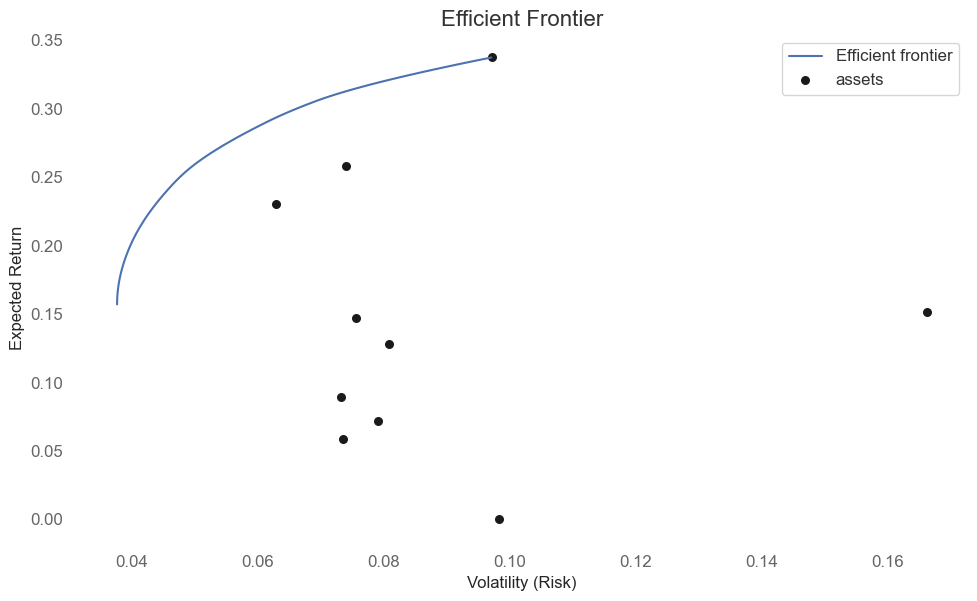

In [56]:
# Create a new EfficientFrontier instance for plotting
ef_for_plot = EfficientFrontier(ER, cov)
plt.figure(figsize=(10, 6))
ax = plot_efficient_frontier(ef_for_plot, show_assets=True)
plt.title("Efficient Frontier", fontsize=16)
plt.xlabel("Volatility (Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.grid()
plt.show()

**Random Portfolio**

In [59]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(ER)), n_samples)
rets = w.dot(ER)
stds = np.sqrt((w.T * (cov @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.1547868  0.12988155 0.20488108 ... 0.14577656 0.13897606 0.16419113]
Sample portfolio volatilities: 0       0.046119
1       0.044143
2       0.061291
3       0.047529
4       0.043146
          ...   
9995    0.046538
9996    0.056441
9997    0.043137
9998    0.057828
9999    0.045285
Length: 10000, dtype: float64


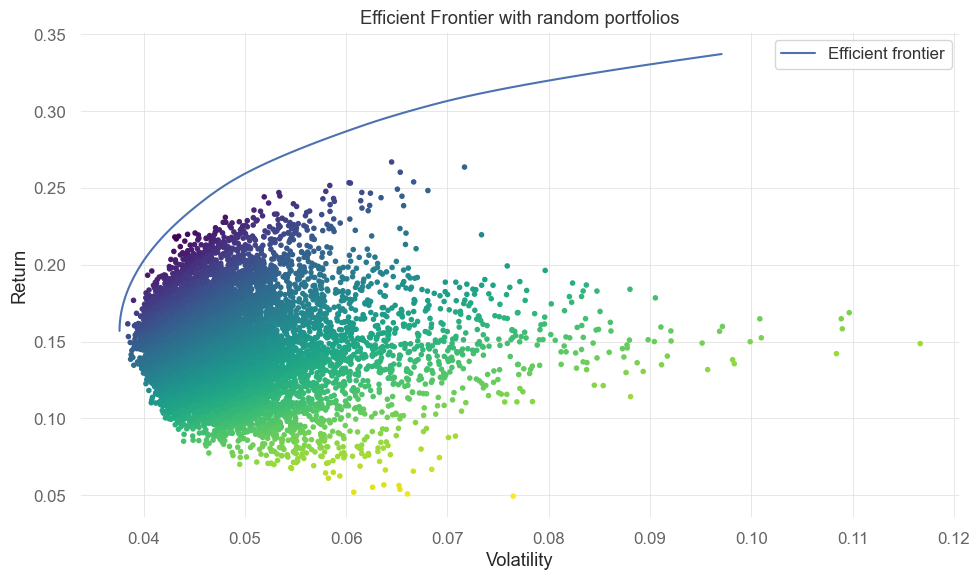

In [61]:
# Plot efficient frontier with Monte Carlo simulation
ef = EfficientFrontier(ER, cov)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(ER, cov)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

**For Minimum votality portfolio**

In [64]:
# Calculating EfficientFrontier 
ef_min = EfficientFrontier(ER, cov)

In [66]:
# Optimizing weights for Minimum votality portfolio 
weights_min = ef_min.min_volatility()
clean_weights_min = ef_min.clean_weights()

In [68]:
# Printing optimized weights and expected performance for portfolio
total_pct = 0
optimal_weight_min = {}
for key, value in clean_weights_min.items():
    if value > 0:
        optimal_weight_min[key] = value
        print(f"Stock: {key}, Weights: {value}")
        total_pct = total_pct + value
        print(f'Total percentage: {total_pct:.2f}')

Stock: TRUE.BK, Weights: 0.08312
Total percentage: 0.08
Stock: IVL.BK, Weights: 0.09933
Total percentage: 0.18
Stock: ADVANC.BK, Weights: 0.16295
Total percentage: 0.35
Stock: DELTA.BK, Weights: 0.01753
Total percentage: 0.36
Stock: KTB.BK, Weights: 0.18243
Total percentage: 0.55
Stock: TTB.BK, Weights: 0.08641
Total percentage: 0.63
Stock: CPF.BK, Weights: 0.08676
Total percentage: 0.72
Stock: MINT.BK, Weights: 0.08215
Total percentage: 0.80
Stock: PTTEP.BK, Weights: 0.19932
Total percentage: 1.00


In [69]:
optimal_weight_min

{'TRUE.BK': 0.08312,
 'IVL.BK': 0.09933,
 'ADVANC.BK': 0.16295,
 'DELTA.BK': 0.01753,
 'KTB.BK': 0.18243,
 'TTB.BK': 0.08641,
 'CPF.BK': 0.08676,
 'MINT.BK': 0.08215,
 'PTTEP.BK': 0.19932}

In [72]:
optimal_weight_min = np.array(list(optimal_weight_min.values()))

In [74]:
expected_return, risk, sharpe = ef_min.portfolio_performance(verbose=True)

Expected annual return: 15.7%
Annual volatility: 3.8%
Sharpe Ratio: 4.17


**Create the beachmark using SET Index and S&P500 Index**

In [77]:
# Standardize the 'Date' column
set_index['Date'] = pd.to_datetime(set_index['Date']).dt.date
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'],utc=True).dt.date

In [79]:
# Merge the dataframe from SET and S&P Index on 'Date'
benchmark_df = pd.merge(set_index, sp500_index,on='Date', how='inner')
benchmark_df = benchmark_df.rename(columns = {'Close_x':'close_set', 'Close_y':'close_sp500'})
benchmark_df = benchmark_df[['close_set' , 'close_sp500', 'Date']]
benchmark_df = benchmark_df.set_index('Date')

In [81]:
# calculating the return on indices 
set_only = benchmark_df['close_set'].to_frame()
sp500_only = benchmark_df['close_sp500'].to_frame()

In [83]:
# Create weight based on the stocks in portfolio 
count_set = 0
count_sp500 = 0
for stock in ER.keys():
    if stock in SET_df.columns:
        count_set = count_set + 1
    else:
        stock in sp500_df.columns
        count_sp500 = count_sp500 + 1

weights_set = count_set/(count_set+count_sp500)
weights_sp500 = 1-weights_set

print(f"Total stocks in SET is: {count_set}")
print(f"Total stocks in SP500 is: {count_sp500}")

Total stocks in SET is: 10
Total stocks in SP500 is: 0


In [85]:
# Creating benchmark 
benchmark = weights_sp500*sp500_only[-360:]['close_sp500'] + weights_set*set_only[-360:]['close_set']
benchmark = benchmark.pct_change().dropna()
benchmark = benchmark.to_frame()
benchmark = benchmark.rename(columns = {'0': 'weighted benchmark'})

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-06-23   2023-06-23
End Period                 2024-12-11   2024-12-11
Risk-Free Rate             4.32%        4.32%
Time in Market             97.0%        100.0%

Cumulative Return          -4.39%       38.04%
CAGR﹪                     -2.08%       16.33%

Sharpe                     -0.59        3.89
Prob. Sharpe Ratio         14.05%       100.0%
Smart Sharpe               -0.12        0.77
Sortino                    -0.83        7.03
Smart Sortino              -0.16        1.4
Sortino/√2                 -0.58        4.97
Smart Sortino/√2           -0.12        0.99
Omega                      1.85         1.85

Max Drawdown               -19.2%       -10.68%
Longest DD Days            469          225
Volatility (ann.)          11.4%        4.78%
R^2                        0.0          0.0
Information Ratio          0.13         0.13
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-09-28,2023-12-20,2024-05-09,225,-10.684319,-10.564968
2,2023-06-26,2023-07-03,2023-07-13,18,-2.916787,-2.859951
3,2024-10-28,2024-12-03,2024-12-11,45,-2.123369,-1.967716
4,2023-07-25,2023-09-08,2023-09-19,57,-1.841423,-1.838969
5,2024-06-21,2024-06-28,2024-07-09,19,-1.457172,-1.398093


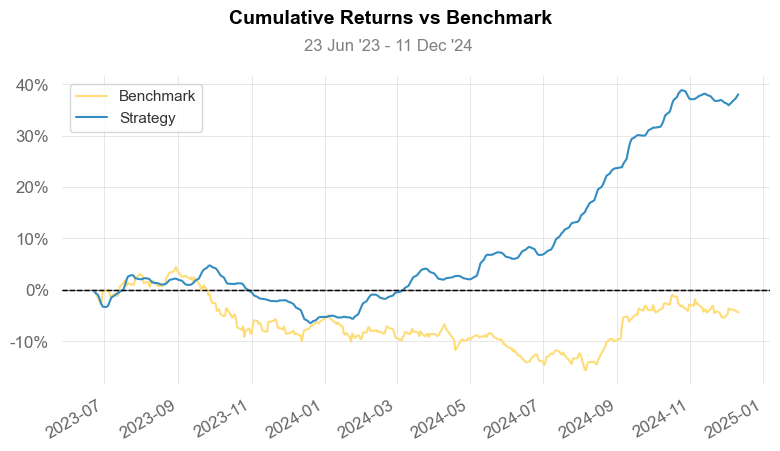

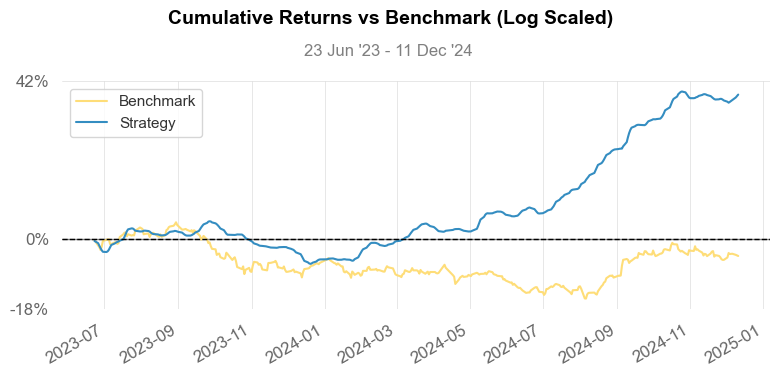

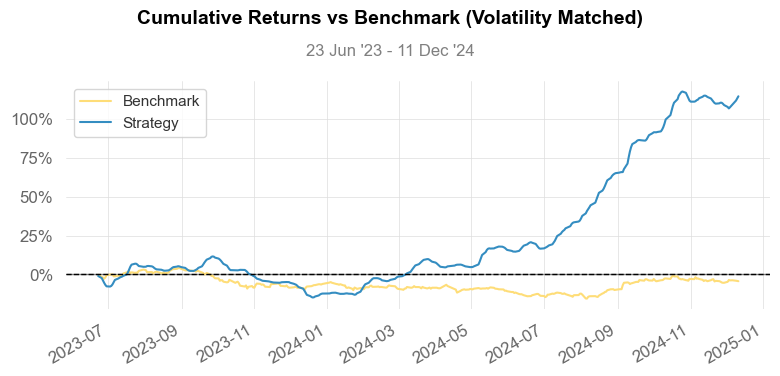

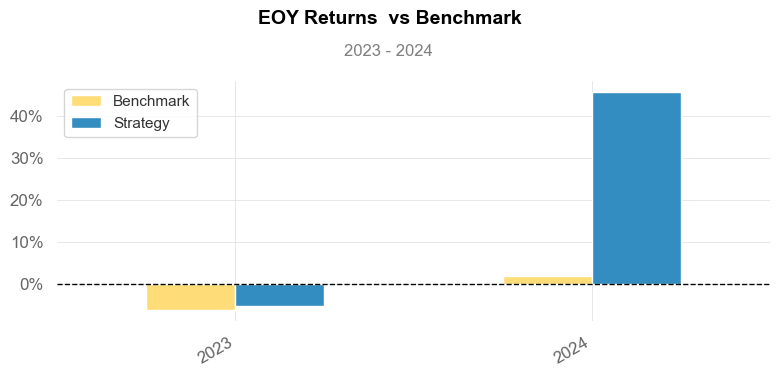

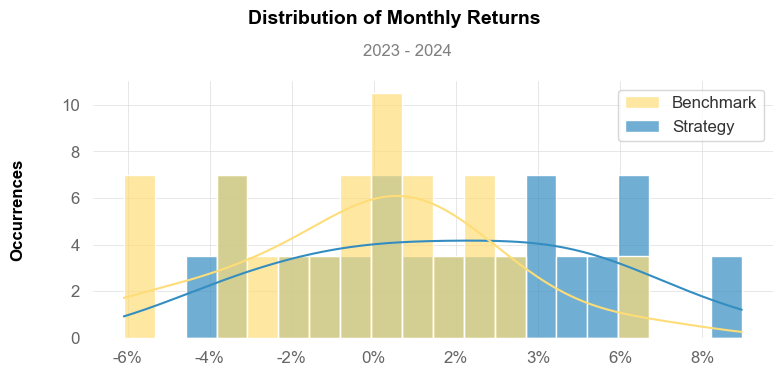

In [87]:
# New reports comparing the optimized portfolio to the first portfolio constructed
optimized_portfolio_max_sharpe.index = pd.to_datetime(optimized_portfolio_max_sharpe.index)
benchmark.index = pd.to_datetime(benchmark.index)

# Convert into series 
optimized_portfolio_max_sharpe = optimized_portfolio_max_sharpe.squeeze() 
benchmark = benchmark.squeeze()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    qs.reports.full(optimized_portfolio_max_sharpe, benchmark=benchmark, rf = risk_free_rate)
except Exception:
    print()

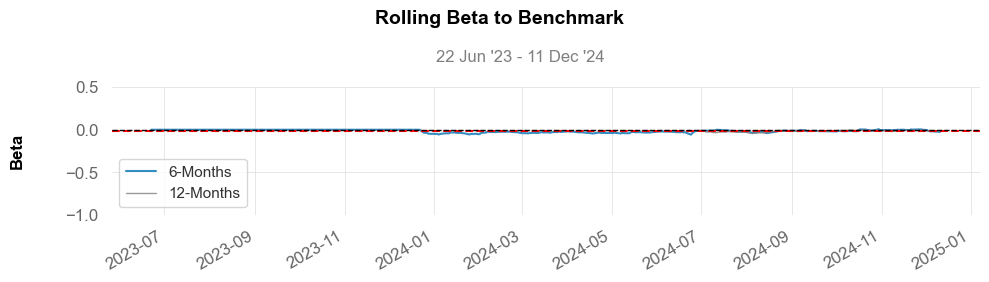

In [89]:
# Rolling beta comparison
qs.plots.rolling_beta(returns=optimized_portfolio_max_sharpe, benchmark=benchmark)

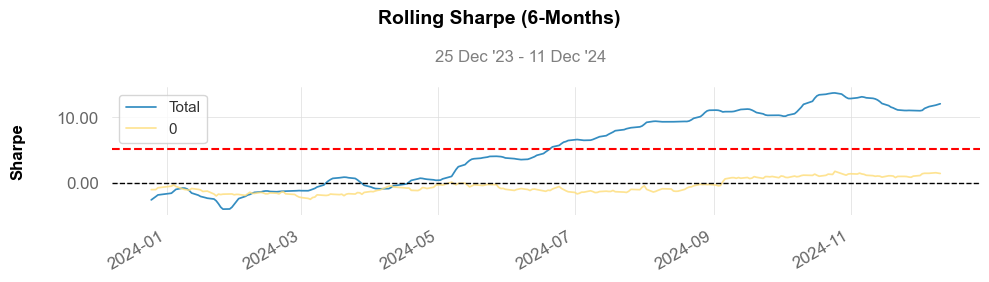

In [90]:
# Rolling sharpe comparison
qs.plots.rolling_sharpe(returns=optimized_portfolio_max_sharpe, benchmark=benchmark)

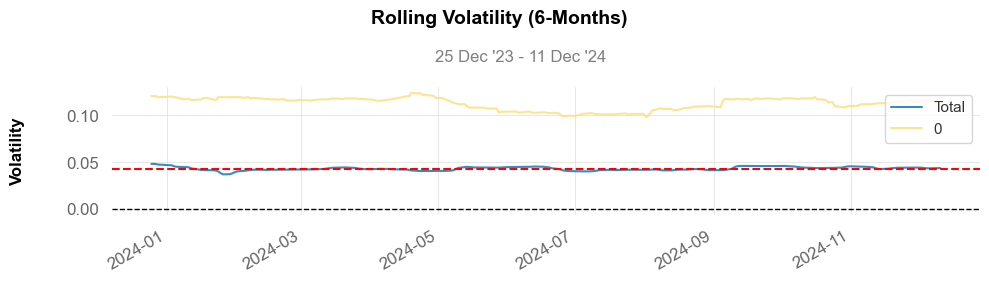

In [92]:
# Rolling volatility comparison
qs.plots.rolling_volatility(returns=optimized_portfolio_max_sharpe, benchmark=benchmark)